In [92]:
# def strategy(df: pd.DataFrame, atr_length: int = 5, sma_length: int = 8, atr_multiplier: float = 1.2) -> pd.DataFrame:
#     df['ATR'] = df.ta.atr(length=atr_length)
#     df['SMA'] = df.ta.sma(close='close', length=sma_length)

#     df['upper_band'] = df['SMA'] + atr_multiplier * df['ATR']
#     df['lower_band'] = df['SMA'] - atr_multiplier * df['ATR']

#     df['buy_signal'] = (df['low'].shift(1) < df['lower_band']) & (df['close'] > df['lower_band'])
#     df['sell_signal'] = (df['high'].shift(1) > df['upper_band']) & (df['close'] < df['upper_band'])

#     df['RSI'] = df.ta.rsi(length=7)
#     df['buy_signal'] = df['buy_signal'] & (df['RSI'] < 30)
#     df['sell_signal'] = df['sell_signal'] & (df['RSI'] > 70)

#     return df

In [93]:
# def backtest(df: pd.DataFrame, initial_balance: float = 10000, risk_per_trade: float = 0.01) -> pd.DataFrame:
#     balance = initial_balance
#     position = 0
#     df = strategy(df)
#     results = []

#     for index, row in df.iterrows():
#         # Entry Conditions
#         if row['buy_signal'] and position == 0:
#             position = balance * risk_per_trade / row['close']
#             balance -= position * row['close']
#             results.append({'Date': index, 'Action': 'Buy', 'Price': row['close'], 'Balance': balance})
        
#         elif row['sell_signal'] and position > 0:
#             balance += position * row['close']
#             position = 0
#             results.append({'Date': index, 'Action': 'Sell', 'Price': row['close'], 'Balance': balance})

#     # Add final balance if still in position
#     if position > 0:
#         balance += position * df.iloc[-1]['close']
#         results.append({'Date': df.index[-1], 'Action': 'Sell', 'Price': df.iloc[-1]['close'], 'Balance': balance})
    
#     results_df = pd.DataFrame(results)
#     return results_df

# Implement Strategy

In [1]:
# import libs
import MetaTrader5 as mt5
import numpy as np
import pandas as pd
import pandas_ta as ta
import time
import datetime as dt
import pytz 
import mplfinance as mpf

In [38]:
def strategy(df: pd.DataFrame) -> pd.DataFrame:
    df['hour'] = df.index.hour
    df['trade_session_filter'] = df['hour'].between(6, 22)

    # Bollinger Bands parameters
    bb_length = 20
    bb_std = 2

    # RSI parameters
    rsi_length = 7
    rsi_threshold_low = 30
    rsi_threshold_high = 70
    bb_width_threshold = 0.0015

    # Bollinger Bands calculations
    bb = df.ta.bbands(length=bb_length, std=bb_std)
    df['BB_Lower'] = bb['BBL_20_2.0']
    df['BB_Mid'] = bb['BBM_20_2.0']
    df['BB_Upper'] = bb['BBU_20_2.0']
    df['bb_width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Mid']
    # RSI calculation
    df['RSI'] = df.ta.rsi(length=rsi_length)

    # ATR calculation for volatility filter
    df['ATR'] = df.ta.atr(length=14)

    # Entry Conditions
    df['buy_signal'] = (
        (df['close'].shift(1) < df['BB_Lower'].shift(1)) &
        (df['RSI'].shift(1) <= rsi_threshold_low)
    )

    df['sell_signal'] = (
        (df['close'].shift(1) > df['BB_Upper'].shift(1)) &
        (df['RSI'].shift(1) >= rsi_threshold_high)
    )

    # Define actions based on entry signals
    df['action'] = np.where(df['buy_signal'], 'buy',
                            np.where(df['sell_signal'], 'sell', None))

    return df

In [95]:
def strategy(df: pd.DataFrame, atr_length: int = 5, sma_length: int = 8, atr_multiplier: float = 1.5) -> pd.DataFrame:
    # Calculate ATR and SMA
    df['ATRr_' + str(atr_length)] = df.ta.atr(length=atr_length)
    df['SMAr_' + str(sma_length)] = df.ta.sma(close=df['close'], length=sma_length)
    macd = df.ta.macd(fast=5, slow=13, signal=3)
    df['macd'], df['macd_signal'], df['macd_hist'] = macd['MACD_5_13_3'], macd['MACDs_5_13_3'], macd['MACDh_5_13_3']
    

    # Calculate Supertrend
    df.ta.supertrend(length=7, multiplier=1.5, append=True)

    # Calculate EMAs
    ema_short_length: int = 9
    ema_long_length: int = 200
    df['EMA_short'] = df.ta.ema(length=ema_short_length)
    df['EMA_long'] = df.ta.ema(close=df['close'], length=ema_long_length)

    df['EMA_200'] = df.ta.ema(close=df['close'], length=200)

    # Define upper and lower bands using ATR and SMA
    df['upper_band_atr1_5'] = df['SMAr_' + str(sma_length)] + atr_multiplier * df['ATRr_' + str(atr_length)]
    df['lower_band_atr1_5'] = df['SMAr_' + str(sma_length)] - atr_multiplier * df['ATRr_' + str(atr_length)]
    df['upper_band_atr1_7'] = df['SMAr_' + str(sma_length)] + 1 * df['ATRr_' + str(atr_length)]
    df['lower_band_atr1_7'] = df['SMAr_' + str(sma_length)] - 1 * df['ATRr_' + str(atr_length)]

    # Define upper and lower bands using ATR and EMA
    df['upper_band_ema'] = df['EMA_short'] + atr_multiplier * df['ATRr_' + str(atr_length)]
    df['lower_band_ema'] = df['EMA_long'] - atr_multiplier * df['ATRr_' + str(atr_length)]

    # Initial buy and sell signals based on price crossing bands
    df['buy_signal_atr_15_sma'] = (df['low'].shift(1) < df['lower_band_atr1_5']) & (df['close'] > df['lower_band_atr1_5'])
    df['sell_signal_atr_15_sma'] = (df['high'].shift(1) > df['upper_band_atr1_5']) & (df['close'] < df['upper_band_atr1_5'])

    df['buy_signal_atr_17_sma'] = (df['low'].shift(1) < df['lower_band_atr1_7']) & (df['close'] > df['lower_band_atr1_7'])
    df['sell_signal_atr_17_sma'] = (df['high'].shift(1) > df['upper_band_atr1_7']) & (df['close'] < df['upper_band_atr1_7'])
    
    # Initial buy and sell signals based on price crossing bands
    df['buy_signal_atr_ema'] = (df['low'].shift(1) < df['lower_band_ema']) & (df['close'] > df['lower_band_ema'])
    df['sell_signal_atr_ema'] = (df['high'].shift(1) > df['upper_band_ema']) & (df['close'] < df['upper_band_ema'])
    
    # Add RSI filter for SMA
    df['RSI'] = df.ta.rsi(length=7)
    df['lower'] = 60 * df['macd'].min() / 100
    df['upper'] = 60 * df['macd'].max() / 100
    
    df['buy_signal_atr_15_sma'] = df['buy_signal_atr_15_sma'] & (df['RSI'] < 30)
    df['sell_signal_atr_15_sma'] = df['sell_signal_atr_15_sma'] & (df['RSI'] > 70)

    df['buy_signal_atr_17_sma'] = df['buy_signal_atr_17_sma'] & (df['RSI'] < 30)
    df['sell_signal_atr_17_sma'] = df['sell_signal_atr_17_sma'] & (df['RSI'] > 70)

    df['buy_signal_atr_ema'] = df['buy_signal_atr_ema'] & (df['RSI'] < 30)
    df['sell_signal_atr_ema'] = df['sell_signal_atr_ema'] & (df['RSI'] > 70)
    

    # Add Supertrend as an additional filter
    df['buy_signal_supertrend'] = (df['SUPERT_7_1.5'] < df['close']) 
    df['sell_signal_supertrend'] = (df['SUPERT_7_1.5'] > df['close']) 

    df['macd_cross_up'] = (df['macd'] > df['macd_signal']) & (df['macd'].shift(1) <= df['macd_signal'].shift(1))
    df['macd_cross_down'] = (df['macd'] < df['macd_signal']) & (df['macd'].shift(1) >= df['macd_signal'].shift(1))

    df['macd_cross_in_overbought'] = df['macd_cross_down'] & (df['RSI'] > 70)
    df['macd_cross_in_oversold'] = df['macd_cross_up'] < df['lower']


    df['impulsed_buy'] = (df['macd_hist'] > 0) & (df['macd_hist'] > df['macd_hist'].shift(1))
    df['impulsed_sell'] = (df['macd_hist'] < 0) & (df['macd_hist'] < df['macd_hist'].shift(1))


    df['buy_signal_macd'] = df['macd'] > df['macd_signal']
    df['sell_signal_macd'] = df['macd'] < df['macd_signal']
        
    # Add volume-based filter (optional)
    volume_threshold = df['volume'].quantile(0.75)
    df['volume_filter'] = df['volume'] > volume_threshold

    df['hour'] = df.index.hour
    df['trade_session_filter'] = df['hour'].between(15, 23)

    
    df['bullish_engulfing'] = (df['open'].shift(1) > df['close'].shift(1)) & (df['open'] < df['close']) & (df['open'] < df['close'].shift(1))
    df['bearish_engulfing'] = (df['open'].shift(1) < df['close'].shift(1)) & (df['open'] > df['close']) & (df['open'] > df['close'].shift(1))

    df['hammer'] = (df['low'] == df['close']) & ((df['high'] - df['low']) > 2 * (df['open'] - df['close']))
    df['shooting_star'] = (df['high'] == df['close']) & ((df['high'] - df['low']) > 2 * (df['close'] - df['open']))

    
    # Combine all signals with volume filter

    df['final_buy_signal'] =  (df['impulsed_buy']) & df['volume_filter']
    df['final_sell_signal'] = (df['impulsed_sell']) & df['volume_filter']
    
    # Determine action
    df['action'] = np.where(df['final_buy_signal'], 'buy',
                            np.where(df['final_sell_signal'], 'sell', None))
    
    return df

In [96]:
def triple_superT(df: pd.DataFrame):
    # Calculating three Supertrend lines with different lengths and multipliers
    supertrend_10_1 = ta.supertrend(df['high'], df['low'], df['close'], length=10, multiplier=1)
    supertrend_11_2 = ta.supertrend(df['high'], df['low'], df['close'], length=11, multiplier=2)
    supertrend_12_3 = ta.supertrend(df['high'], df['low'], df['close'], length=12, multiplier=3)

    df['RSI'] = df.ta.rsi(length=7)
    
    # Add the Supertrend direction to the dataframe (uptrend is 1, downtrend is -1)
    df['supertrend_10_1'] = supertrend_10_1['SUPERTd_10_1.0']
    df['supertrend_11_2'] = supertrend_11_2['SUPERTd_11_2.0']
    df['supertrend_12_3'] = supertrend_12_3['SUPERTd_12_3.0']

    df['supertrend_support'] = supertrend_10_1['SUPERTs_10_1.0']
    df['supertrend_level'] = supertrend_10_1['SUPERTl_10_1.0']

    df['SUPERTl_10_1.0'] = supertrend_10_1['SUPERTl_10_1.0']
    df['SUPERTl_11_2.0'] = supertrend_11_2['SUPERTl_11_2.0']
    df['SUPERTl_12_3.0'] = supertrend_12_3['SUPERTl_12_3.0']
    df['SUPERTs_10_1.0'] = supertrend_10_1['SUPERTs_10_1.0']
    df['SUPERTs_11_2.0'] = supertrend_11_2['SUPERTs_11_2.0']
    df['SUPERTs_12_3.0'] = supertrend_12_3['SUPERTs_12_3.0']

    volume_threshold = df['volume'].quantile(0.75)
    df['volume_filter'] = df['volume'] > volume_threshold
    
    # Buy signal: all supertrends are in an uptrend (i.e., all equal 1)
    df['buy_signal'] = (
        (
            (df['supertrend_10_1'].shift(1) == -1) 
            | (df['supertrend_11_2'].shift(1) == -1) 
            | (df['supertrend_12_3'].shift(1) == -1)
        ) &
        (df['supertrend_10_1'] == 1) 
        & (df['supertrend_11_2'] == 1) 
        & (df['supertrend_12_3'] == 1)
    )

    df['close_buy_signal'] = (
        ((df['supertrend_10_1'] == -1) & (df['supertrend_10_1'].shift(1)== 1))
        | ((df['supertrend_11_2'] == -1) & (df['supertrend_11_2'].shift(1)== 1))
        | ((df['supertrend_12_3'] == -1) & (df['supertrend_12_3'].shift(1)== 1))
    )
    
    # Sell signal: all supertrends are in a downtrend (i.e., all equal -1)
    df['sell_signal'] = (
        (df['supertrend_10_1'] == -1) 
        & (df['supertrend_11_2'] == -1) 
        & (df['supertrend_12_3'] == -1)
    )
    
    df['close_sell_signal'] = (df['supertrend_10_1'] == 1) | (df['supertrend_11_2'] == 1) | (df['supertrend_12_3'] == 1)

    df['action'] = np.where(df['buy_signal'], 'buy',
                          np.where(df['close_buy_signal'], 'sell', None))

    return df

In [97]:
def supertrend_ema(df: pd.DataFrame) -> pd.DataFrame:
  # Calculate Supertrend (length=10, multiplier=3)
  df.ta.supertrend(length=10, multiplier=3, append=True)
  
  # Calculate EMA (length=200)
  df['EMA_200'] = df.ta.ema(length=200)
  
  # Define Supertrend columns
  supertrend_col = 'SUPERT_10_3.0'
  supertrend_direction_col = 'SUPERTd_10_3.0'
  
  df = engulfing(df=df)

  # Define conditions for buy and sell signals
  df['buy_signal'] = (df[supertrend_direction_col] == 1) & (df['EMA_200'] < df[supertrend_col]) & df['C_EngulfingBullish']
  df['sell_signal'] = (df[supertrend_direction_col] == -1) & (df['EMA_200'] > df[supertrend_col])  & df['C_EngulfingBearish']

    # Determine action
  df['action'] = np.where(df['buy_signal'], 'buy',
                          np.where(df['sell_signal'], 'sell', None))

  return df

In [98]:
def tripleEMA(df: pd.DataFrame) -> pd.DataFrame:
    # calculate EMA20
    df['EMA_50'] = df.ta.ema(length=50)
    # calcualte EMA50
    df['EMA_100'] = df.ta.ema(length=100)
    # calcualte EMA100
    df['EMA_150'] = df.ta.ema(length=150)
    # calculate ATR for SL, TP
    df['ATR'] = df.ta.atr(length=7)
    # get williams fractral
    df = williams_fractal_(df=df)
    df['uptrend'] = (df['EMA_50'] > df['EMA_100']) & (df['EMA_100'] > df['EMA_150'])
    df['downtrend'] = (df['EMA_50'] < df['EMA_100']) & (df['EMA_100'] < df['EMA_150'])
    # Pullback conditions
    df['pullback_buy'] = (df['low'] < df['EMA_50']) | (df['low'] < df['EMA_100']) & (df['low'] > df['EMA_150'])
    df['pullback_sell'] = (df['low'] > df['EMA_50']) & (df['low'] < df['EMA_100'])
    # Buy Signal (pullback + fractal confirmation)
    df['buy_signal'] = df['pullback_buy'] &  df['downFractal'].shift(2)
    # Sell Signal (pullback + fractal confirmation)
    df['sell_signal'] = df['pullback_sell'] &  df['upFractal'].shift(2)

    df['action'] = np.where(df['buy_signal'], 'buy',
                            np.where(df['sell_signal'], 'sell', None))

    return df

In [99]:
def smooth_heiken_ashi(df: pd.DataFrame) -> pd.DataFrame:
    df['Close'] = df['close'].ewm(span=10, adjust=False).mean()
    df['Open'] = df['open'].ewm(span=10, adjust=False).mean()
    df['High'] = df['high'].ewm(span=10, adjust=False).mean()
    df['Low'] = df['low'].ewm(span=10, adjust=False).mean()

    df['ema'] = df.ta.ema(length=200, close='close')
    df['SAR'] = ta.psar(df['high'], df['low'], af=0.02, max_af=0.2)['PSARl_0.02_0.2']

    df['uptrend'] = df['Close'] > df['ema']
    df['downtrend'] = df['Close'] < df['ema']

    # df['RSI'] = df.ta.rsi(length=7)
    # df['fast'] = df.ta.sma(length=12)
    # df['slow'] = df.ta.sma(length=26)
    # macd = df.ta.macd(fast=12, slow=26, signal=9, close='close')
    # df['macd'], df['macd_signal'], df['macd_hist'] = macd['MACD_12_26_9'], macd['MACDs_12_26_9'], macd['MACDh_12_26_9']

    df.drop(columns=['close', 'open', 'high', 'low'], inplace=True)
    # print(df.columns)

    df['Heiken_Close'] = (df['Open']+df['Close']+df['High']+df['Low'])/4
    df['Heiken_Open'] = df['Open'].copy()
    for i in range(1, len(df)):
        df.loc[df.index[i], 'Heiken_Open'] = (df.loc[df.index[i-1], 'Heiken_Open'] + df.loc[df.index[i-1], 'Heiken_Close']) / 2

    df['Heiken_High'] = df[['High', 'Heiken_Open', 'Heiken_Close']].max(axis=1)
    df['Heiken_Low'] = df[['Low', 'Heiken_Open', 'Heiken_Close']].min(axis=1)

    df['no_lower_wick'] = df['Heiken_Low'] == df[['Heiken_Open', 'Heiken_Close']].min(axis=1)
    df['no_upper_wick'] = df['Heiken_High'] == df[['Heiken_Open', 'Heiken_Close']].max(axis=1)

    df['Pivot_Green'] = (df['Heiken_Close'] > df['Heiken_Open']) & (df['Heiken_Low'] == df['Heiken_Open'])
    df['Pivot_Red'] = (df['Heiken_Close'] < df['Heiken_Open']) & (df['Heiken_High'] == df['Heiken_Open'])
    
    
    df.rename(columns={
        'Heiken_Open':'open',
        'Heiken_High':'high',
        'Heiken_Low':'low',
        'Heiken_Close':'close'
    }, inplace=True)

    df.drop(columns=['Close', 'Open', 'High', 'Low'], inplace=True)
    
    # df.dropna(inplace=True)
    return df

In [100]:
def superTdema(df: pd.DataFrame) -> pd.DataFrame:

    df['DEMA_200'] = df.ta.dema(length=200, close=df['close'])

    # Assuming df contains the OHLC data
    df['hl2'] = (df['high'] + df['low']) / 2

    # Calculate Supertrend (using pandas-ta for simplicity)
    supertrend = ta.supertrend(df['high'], df['low'], df['close'], length=12, multiplier=3)
    df['supertrend'] = supertrend['SUPERT_12_3.0']  # Adjust based on your parameters
    df['supertrend_direction'] = supertrend['SUPERTd_12_3.0']  # Trend direction: 1 for uptrend, -1 for downtrend
    df['supertrend_support'] = supertrend['SUPERTs_12_3.0']
    df['supertrend_level'] = supertrend['SUPERTl_12_3.0']


    df['buy_signal_supertrend'] = (df['supertrend_direction'] > 0) & (df['supertrend_direction'].shift(1) <= 0)
    df['sell_signal_supertrend'] = (df['supertrend_direction'] < 0) & (df['supertrend_direction'].shift(1) >= 0)
    

    df['buy_signal'] =  (df['buy_signal_supertrend']) & (df['close'] > df['DEMA_200'])
    df['sell_signal'] = (df['sell_signal_supertrend']) & (df['close'] < df['DEMA_200'])
    
    # Determine action
    df['action'] = np.where(df['buy_signal'], 'buy',
                            np.where(df['sell_signal'], 'sell', None))

    return df

In [101]:
def detect_trend(df, body_size_threshold=0.1):
    # Calculate the body size of each Heiken Ashi candle (HA_Close - HA_Open)
    df['HA_Body_Size'] = abs(df['HA_Close_Smooth'] - df['HA_Open_Smooth'])
    
    # Detect trends based on smoothed Heiken Ashi and body size
    df['Trend'] = 0  # Neutral
    
    # Uptrend: 3 consecutive bullish candles with increasing body size
    df['Bullish_Condition'] = (
        (df['HA_Close_Smooth'] > df['HA_Open_Smooth']) &  # Bullish candle
        (df['HA_Body_Size'] > df['HA_Body_Size'].shift(1)) &  # Larger body size than previous
        (df['HA_Body_Size'].shift(1) > df['HA_Body_Size'].shift(2))  # Larger than the one before that
    )
    
    # Downtrend: 3 consecutive bearish candles with increasing body size
    df['Bearish_Condition'] = (
        (df['HA_Close_Smooth'] < df['HA_Open_Smooth']) &  # Bearish candle
        (df['HA_Body_Size'] > df['HA_Body_Size'].shift(1)) &  # Larger body size than previous
        (df['HA_Body_Size'].shift(1) > df['HA_Body_Size'].shift(2))  # Larger than the one before that
    )

    # Assign trend: 1 for uptrend, -1 for downtrend
    df.loc[df['Bullish_Condition'], 'Trend'] = 1
    df.loc[df['Bearish_Condition'], 'Trend'] = -1
    
    return df

In [102]:
def engulfing(df: pd.DataFrame, trend_rule: str = 'SMA50'):

   df['C_DownTrend'] = True
   df['C_UpTrend'] = True

   if trend_rule == 'SMA50':
      df['priceAvg'] = df.ta.sma(length=50)
      df['C_DownTrend'] &= df['close'] < df['priceAvg']
      df['C_UpTrend'] &= df['close'] > df['priceAvg']

   if trend_rule == 'SMA50, SMA200':
      df['sma50'] = df.ta.sma(length=50)
      df['sma200'] = df.ta.sma(length=200)
      df['C_DownTrend'] &= (df['close'] < df['sma50']) & (df['sma50'] < df['sma200'])
      df['C_UpTrend'] &= (df['close'] > df['sma50']) & (df['sma50'] > df['sma200'])

   df['C_BodyHi'] = df[['open', 'close']].max(axis=1)
   df['C_BodyLo'] = df[['open', 'close']].min(axis=1)
   df['C_Body'] = df['C_BodyHi'] - df['C_BodyLo']


   df['C_BodyAvg'] = ta.ema(close=df['C_Body'], length=7)

   # Small and long body conditions
   df['C_SmallBody'] = df['C_Body'] < df['C_BodyAvg']
   df['C_LongBody'] = df['C_Body'] > df['C_BodyAvg']

   # Identify basic candle types
   df['Bullish Candle'] = df['close'] > df['open']
   df['Bearish Candle'] = df['close'] < df['open']
   df['Prev Bullish'] = df['close'].shift(1) > df['open'].shift(1)
   df['Prev Bearish'] = df['close'].shift(1) < df['open'].shift(1)

   # Bearish engulfing conditions
   df['Prev Close < Curr Open'] = df['close'].shift(1) < df['open']
   df['Prev Open > Curr Close'] = df['open'].shift(1) > df['close']

   # Bullish engulfing conditions
   df['Bearish Close > Bullish Open'] = df['close'].shift(1) > df['open']
   df['Bearish Open < Bullish Close'] = df['open'].shift(1) < df['close']

   # Identify the patterns
   df['C_EngulfingBullish'] = (df['Bullish Candle'] & 
                              df['Prev Bearish'] & 
                              df['Bearish Close > Bullish Open'] & 
                              df['Bearish Open < Bullish Close'] 
                              & df['C_LongBody'] 
                              & df['C_SmallBody'].shift(1)
                              )
   
   df['C_EngulfingBearish'] = (df['Bearish Candle'] & 
                              df['Prev Bullish'] & 
                              df['Prev Close < Curr Open'] & 
                              df['Prev Open > Curr Close'] 
                           #    & df['C_LongBody'] 
                           #    &df['C_SmallBody'].shift(1) 
                               )

   df['action'] = np.where(df['C_EngulfingBullish'], 'buy',
                          np.where(df['C_EngulfingBearish'], 'sell', None))
   
   return df

In [103]:
def engulfing_candle(df: pd.DataFrame):
    pass

In [104]:
def rsi_200EMA_engulf(df: pd.DataFrame):
    df['RSI'] = df.ta.rsi(length=7)
    df['EMA_200'] = df.ta.ema(length=200, close='close')

    # get engulf candle
    df = engulfing(df=df)

    df['uptrend'] = df['close'] > df['EMA_200']
    df['downtrend'] = df['close'] < df['EMA_200']

    df['buy_signal'] = df['uptrend'] & df['C_EngulfingBullish']  & (df['RSI'] < 50)
    df['sell_signal'] = df['downtrend'] & df['C_EngulfingBearish']  & (df['RSI'] > 50)

    df['action'] = np.where(df['buy_signal'], 'buy',
                           np.where(df['sell_signal'], 'sell', None))

    return df


In [105]:
def williams_fractal_(df: pd.DataFrame) -> pd.DataFrame:
    
    # Define the number of periods (n)
    n = 9  # You can change this value as needed

    for i in range(1, n+1):  # Shift up to n + 4 periods ahead, as per Pine Script logic
        df[f'high_prev_{i}'] = df['high'].shift(i)
        df[f'high_next_{i}'] = df['high'].shift(-i)
        df[f'low_prev_{i}'] = df['low'].shift(i)
        df[f'low_next_{i}'] = df['low'].shift(-i)

    # Replace NaN values resulting from shifting with appropriate values for comparison
    df.fillna({'high_prev_1': -np.inf, 'high_next_1': -np.inf, 
           'low_prev_1': np.inf, 'low_next_1': np.inf}, inplace=True)


   # Up Fractal Logic
    df['upflagDownFrontier'] = True
    df['upflagUpFrontier'] = True
    
    # Check if current high is greater than the previous and next highs within 'n' periods
    for i in range(1, n+1):
        df['upflagDownFrontier'] &= df[f'high_prev_{i}'] < df['high']
        df['upflagUpFrontier'] &= df[f'high_next_{i}'] < df['high']
    
    df['upFractal'] = df['upflagDownFrontier'] & df['upflagUpFrontier']

    # Down Fractal Logic
    df['downflagDownFrontier'] = True
    df['downflagUpFrontier'] = True

    # Check if current low is lower than the previous and next lows within 'n' periods
    for i in range(1, n+1):
        df['downflagDownFrontier'] &= df[f'low_prev_{i}'] > df['low']
        df['downflagUpFrontier'] &= df[f'low_next_{i}'] > df['low']

    df['downFractal'] = df['downflagDownFrontier'] & df['downflagUpFrontier']

    # Clean up the temporary columns
    df.drop(columns=[col for col in df.columns if 'high_prev' in col or 'high_next' in col or 'low_prev' in col or 'low_next' in col], inplace=True)
    
    return df

In [106]:
def heiken_ashi_trade(df: pd.DataFrame) -> pd.DataFrame:
    

    # # convert to heiken ashi candle
    # heiken_df = smooth_heiken_ashi(df=df)

    # heiken_df = is_doji(df=heiken_df)

    # heiken_df['candle_color'] = np.where(heiken_df['close'] > heiken_df['open'], 'green',
    #                                 np.where(heiken_df['open'] > heiken_df['close'], 'red', None)) 

    # heiken_df['Recent_3_Red'] = (heiken_df['candle_color'] == 'red').rolling(window=10).sum() >= 3
    # # Look for at least 3 green candles within the last 5-10 bars
    # heiken_df['Recent_3_Green'] = (heiken_df['candle_color'] == 'green').rolling(window=10).sum() >= 3

    # volume_threshold = heiken_df['volume'].rolling(window=7).mean()
    # heiken_df['volume_filter'] = heiken_df['volume'] > volume_threshold

    # heiken_df['Body_Size'] = abs(heiken_df['close'] - heiken_df['open'])
    # heiken_df['C_BodyAvg'] = ta.ema(close=heiken_df['Body_Size'], length=7)
    # heiken_df['C_SmallBody'] = heiken_df['Body_Size'] < heiken_df['C_BodyAvg']

    heiken_ashi = ta.ha(df['open'], df['high'], df['low'], df['close'])
    # Add Heiken Ashi candles to the dataframe
    df['HA_Open'], df['HA_High'], df['HA_Low'], df['HA_Close'] = heiken_ashi['HA_open'], heiken_ashi['HA_high'], heiken_ashi['HA_low'], heiken_ashi['HA_close']
    # EMA 200 Calculation
    df['EMA200'] = ta.ema(df['close'], length=20)
    # Parabolic SAR Calculation
    df['SAR'] = ta.psar(df['high'], df['low'], af=0.02, max_af=0.2)['PSARl_0.02_0.2']
    # Detect pivots (Heiken Ashi candles without tails)
    df['Pivot_Green'] = (df['HA_Close'] > df['HA_Open']) & (df['HA_Low'] == df['HA_Open'])
    df['Pivot_Red'] = (df['HA_Close'] < df['HA_Open']) & (df['HA_High'] == df['HA_Open'])
    # Identify Red and Green Heiken Ashi candles
    df['HA_Red'] = df['HA_Close'] < df['HA_Open']
    df['HA_Green'] = df['HA_Close'] > df['HA_Open']
    # Look for at least 3 red candles within the last 5-10 bars
    df['Recent_3_Red'] = df['HA_Red'].rolling(window=5).sum() >= 3

    # Look for at least 3 green candles within the last 5-10 bars
    df['Recent_3_Green'] = df['HA_Green'].rolling(window=5).sum() >= 3

    df.drop(columns=['close', 'open', 'high', 'low'], inplace=True)

    df.rename(columns={
        'HA_Open':'open',
        'HA_High':'high',
        'HA_Low':'low',
        'HA_Close':'close'
    }, inplace=True)

    # heiken_df['buy_signal'] = (
    #     # (heiken_df['candle_color'].shift(3) == 'green') &
    #     # (heiken_df['candle_color'].shift(2) == 'green') &
    #     # (heiken_df['candle_color'].shift(1) == 'green') &
    #     # (heiken_df['candle_color'] == 'green') &
    #     # ((heiken_df['Body_Size'].shift(3)) < heiken_df['Body_Size'].shift(2)) &
    #     # ((heiken_df['Body_Size'].shift(2)) < heiken_df['Body_Size'].shift(1)) & 
    #     # ((heiken_df['Body_Size'].shift(1)) < heiken_df['Body_Size']) &
    #     # (heiken_df['no_lower_wick'].shift(1)) &
    #     # (heiken_df['RSI'] < 70)
    #     # (heiken_df['fast'] > heiken_df['slow'])
    #     # heiken_df['uptrend'] &
    #     # (heiken_df['SAR'] < heiken_df['close']) &
    #     # heiken_df['Recent_3_Red'] &
    #     # heiken_df['Pivot_Green']
    # )

    # heiken_df['sell_signal'] = (
    #     # (heiken_df['candle_color'].shift(3) == 'red') &
    #     # (heiken_df['candle_color'].shift(2) == 'red') &
    #     # (heiken_df['candle_color'].shift(1) == 'red') &
    #     # (heiken_df['candle_color'] == 'red') &
    #     # (heiken_df['Body_Size'].shift(3) < heiken_df['Body_Size'].shift(2)) &
    #     # (heiken_df['Body_Size'].shift(2) < heiken_df['Body_Size'].shift(1)) &
    #     # (heiken_df['Body_Size'].shift(1) < heiken_df['Body_Size']) &
    #     # (heiken_df['no_upper_wick'].shift(1)) &
    #     # (heiken_df['RSI'] > 30)
    #     # (heiken_df['fast'] < heiken_df['slow'])
    #     heiken_df['downtrend'] &
    #     (heiken_df['SAR'] > heiken_df['close']) &
    #     heiken_df['Recent_3_Green'] &
    #     heiken_df['Pivot_Red']
    # )

    df['buy_signal'] = (
        # (df['close'] > df['EMA200']) & 
        (df['SAR'] < df['close']) & 
        df['Recent_3_Red'] &
        df['Pivot_Green']
    )

    df['sell_signal'] = (
        # (df['close'] < df['EMA200']) & 
        (df['SAR'] > df['close']) & 
        df['Recent_3_Green'] &
        df['Pivot_Red']
    )

    
    # # Determine action
    # heiken_df['action'] = np.where(heiken_df['buy_signal'] , 'buy',
    #                         np.where(heiken_df['sell_signal'], 'sell', None))

    # Determine action
    df['action'] = np.where(df['buy_signal'] , 'buy',
                            np.where(df['sell_signal'], 'sell', None))

    return df

In [107]:
def is_doji(df: pd.DataFrame) -> pd.DataFrame:

    temp_df = df.copy()

    C_Len = 14 # ta.ema depth for bodyAvg
    C_ShadowPercent = 5.0 # size of shadows
    C_ShadowEqualsPercent = 100.0
    C_DojiBodyPercent = 15.0
    C_Factor = 2.0 # shows the number of times the shadow dominates the candlestick body

    temp_df['C_BodyHi'] = temp_df[['open', 'close']].max(axis=1)
    temp_df['C_BodyLo'] = temp_df[['open', 'close']].min(axis=1)
    temp_df['C_Body'] = temp_df['C_BodyHi'] - temp_df['C_BodyLo']

    temp_df['C_UpShadow'] = temp_df['high'] - temp_df['C_BodyHi']
    temp_df['C_DnShadow'] = temp_df['C_BodyLo'] - temp_df['low']

    temp_df['C_Range'] = temp_df['high']-temp_df['low']

    temp_df['C_ShadowEquals'] = (temp_df['C_UpShadow'] == temp_df['C_DnShadow']) | \
        ((abs(temp_df['C_UpShadow'] - temp_df['C_DnShadow']) / temp_df['C_DnShadow'] * 100) < C_ShadowEqualsPercent) \
             & ((abs(temp_df['C_DnShadow'] - temp_df['C_UpShadow']) / temp_df['C_UpShadow'] * 100) < C_ShadowEqualsPercent)

    temp_df['C_IsDojiBody'] = (temp_df['C_Range'] > 0) & (temp_df['C_Body'] <= temp_df['C_Range'] * C_DojiBodyPercent / 100)
    temp_df['is_doji'] = temp_df['C_IsDojiBody'] & temp_df['C_ShadowEquals']

    df['is_doji'] = temp_df['is_doji']

    return df

In [108]:
def hama(df:pd.DataFrame) -> pd.DataFrame:
    pass

In [52]:
# fetch data
timezone = pytz.timezone("Asia/Bangkok")
tf = mt5.TIMEFRAME_M15
mt5.initialize()

def get_data(start_date: str, end_date: str, copy_range: bool) -> pd.DataFrame:
    start_datetime = dt.datetime.strptime(start_date, '%Y-%m-%d')
    end_datetime = dt.datetime.strptime(end_date, '%Y-%m-%d')
    
    if copy_range:
        data = mt5.copy_rates_range('XAUUSDm', tf, start_datetime, end_datetime)
    else:
        data = mt5.copy_rates_from('XAUUSDm', tf, dt.datetime.now(), 250)
    df = pd.DataFrame(data)
    df['time'] = pd.to_datetime(df['time'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Etc/GMT-7')
    df.rename(columns={
        'time':'Date', 
        'tick_volume':'volume'}, inplace=True)
    df.set_index('Date', inplace=True)
    return df

In [53]:
df = get_data(start_date='2024-10-4', end_date='2024-10-18', copy_range=False)
df_plot = df.copy()
df_plot

,open,high,low,close,volume,spread,real_volume
Date,,,,,,,
2025-01-23 03:15:00+07:00,2756.092,2756.291,2755.417,2755.932,1212,160,0
2025-01-23 03:30:00+07:00,2755.890,2756.010,2754.802,2755.949,1415,160,0
2025-01-23 03:45:00+07:00,2755.978,2757.127,2755.482,2756.626,1596,160,0
2025-01-23 04:00:00+07:00,2756.591,2757.097,2755.946,2756.363,704,160,0
2025-01-23 04:15:00+07:00,2756.405,2756.505,2755.079,2755.468,700,160,0
...,...,...,...,...,...,...,...
2025-01-27 19:30:00+07:00,2762.578,2763.744,2760.413,2762.789,3273,159,0
2025-01-27 19:45:00+07:00,2762.866,2763.809,2761.180,2761.372,2487,159,0
2025-01-27 20:00:00+07:00,2761.340,2762.434,2757.829,2761.695,4178,159,0


In [54]:
df = strategy(df=df)
# df = supertrend_ema(df=df)
# df = supertrend_3line(df=df)
# df = tripleEMA(df=df)
# df = superTdema(df=df)
# df = triple_superT(df=df)
# df = heiken_ashi(df=df)
# df = engulfing(df=df)
# df = williams_fractal_(df=df)
# df = rsi_200EMA_engulf(df=df)
# df = heiken_ashi_trade(df=df)

df

,open,high,low,close,volume,spread,real_volume,hour,trade_session_filter,BB_Lower,BB_Mid,BB_Upper,bb_width,RSI,ATR,buy_signal,sell_signal,action
Date,,,,,,,,,,,,,,,,,,
2025-01-23 03:15:00+07:00,2756.092,2756.291,2755.417,2755.932,1212,160,0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,None
2025-01-23 03:30:00+07:00,2755.890,2756.010,2754.802,2755.949,1415,160,0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,None
2025-01-23 03:45:00+07:00,2755.978,2757.127,2755.482,2756.626,1596,160,0,3,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,None
2025-01-23 04:00:00+07:00,2756.591,2757.097,2755.946,2756.363,704,160,0,4,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,None
2025-01-23 04:15:00+07:00,2756.405,2756.505,2755.079,2755.468,700,160,0,4,False,NaN,NaN,NaN,NaN,NaN,NaN,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-27 19:30:00+07:00,2762.578,2763.744,2760.413,2762.789,3273,159,0,19,True,2752.329620,2763.20500,2774.080380,0.007872,41.131753,3.810626,False,False,None
2025-01-27 19:45:00+07:00,2762.866,2763.809,2761.180,2761.372,2487,159,0,19,True,2754.864093,2763.79970,2772.735307,0.006466,36.724722,3.726224,False,False,None
2025-01-27 20:00:00+07:00,2761.340,2762.434,2757.829,2761.695,4178,159,0,20,True,2756.232455,2764.16030,2772.088145,0.005736,38.477717,3.788994,False,False,None


In [56]:
df.loc[df['action'] == 'buy', 'marker_position'] = df['low']
df.loc[df['action'] == 'sell', 'marker_position'] = df['high']
df[df['marker_position'].notnull()]
# df[(df['volume_filter']==True) & (df['marker_position'].notnull())]

,open,high,low,close,volume,spread,real_volume,hour,trade_session_filter,BB_Lower,BB_Mid,BB_Upper,bb_width,RSI,ATR,buy_signal,sell_signal,action,marker_position
Date,,,,,,,,,,,,,,,,,,,
2025-01-23 10:30:00+07:00,2750.696,2750.733,2749.632,2749.968,1948,159,0,10,True,2750.582159,2753.86490,2757.147641,0.002384,16.600769,1.826374,True,False,buy,2749.632
2025-01-23 10:45:00+07:00,2749.969,2750.309,2749.540,2749.972,1901,159,0,10,True,2750.038761,2753.55525,2757.071739,0.002554,16.680825,1.737975,True,False,buy,2749.540
2025-01-23 11:00:00+07:00,2750.023,2752.379,2749.772,2752.331,1362,160,0,11,True,2749.938508,2753.41485,2756.891192,0.002525,49.821739,1.809754,True,False,buy,2749.772
2025-01-23 16:30:00+07:00,2743.808,2744.934,2740.844,2743.224,3533,159,0,16,True,2746.155651,2752.03965,2757.923649,0.004276,13.001623,2.534060,True,False,buy,2740.844
2025-01-23 16:45:00+07:00,2743.263,2747.313,2742.602,2745.833,3892,159,0,16,True,2745.270675,2751.74815,2758.225625,0.004708,31.308870,2.693476,True,False,buy,2742.602
2025-01-23 20:45:00+07:00,2737.887,2742.150,2737.784,2741.525,5083,159,0,20,True,2737.536978,2746.74535,2755.953722,0.006705,38.539196,3.922874,True,False,buy,2737.784
2025-01-23 23:45:00+07:00,2754.280,2757.440,2753.344,2753.980,3713,159,0,23,False,2736.731907,2745.35135,2753.970793,0.006279,69.543759,4.361447,False,True,sell,2757.440
2025-01-24 00:15:00+07:00,2755.183,2755.578,2753.946,2755.081,2346,159,0,0,False,2735.763370,2746.11465,2756.465930,0.007539,70.996019,4.090721,False,True,sell,2755.578
2025-01-24 07:45:00+07:00,2760.153,2761.086,2759.554,2759.693,1251,159,0,7,True,2750.936390,2755.05785,2759.179310,0.002992,74.778430,2.235786,False,True,sell,2761.086


In [29]:
# df.loc[df['upFractal'] == True, 'marker_position'] = df['close'] + 1
# df.loc[df['downFractal'] == True, 'marker_position'] = df['close'] - 1
# df[df['marker_position'].notnull()]
# df[(df['volume_filter']==True) & (df['marker_position'].notnull())]

KeyError: 'upFractal'

In [57]:
markers = ['^' if x == 'buy' else 'v' for x in df['action']]
color_marker = ['green' if x == 'buy' else 'red' for x in df['action']]
marker_plot = mpf.make_addplot(df['marker_position'], type='scatter', marker=markers, color=color_marker)

In [117]:
# William Fractal
# markers = ['^' if x == True else 'v' for x in df['upFractal']]
# color_marker = ['green' if x == True else 'red' for x in df['upFractal']]
# marker_plot = mpf.make_addplot(df['marker_position'], type='scatter', marker=markers, color=color_marker)

In [118]:
# lower_15_plot = mpf.make_addplot(df['lower_band_atr1_5'], panel = 0, color='orange')
# upper_15_plot = mpf.make_addplot(df['upper_band_atr1_5'], panel = 0, color='orange')

In [119]:
# sma_plot = mpf.make_addplot(df['SMA_50'], panel = 0, color ='blue')

In [120]:
# ema_long_plot = mpf.make_addplot(df['lower_band_ema'], panel = 0, color ='purple')
# ema_short_plot = mpf.make_addplot(df['upper_band_ema'], panel = 0, color ='purple')

In [121]:
# low_plot = mpf.make_addplot(df['lower'], panel = 1, color ='red', ylim=(-5,5))
# up_plot = mpf.make_addplot(df['upper'], panel = 1, color ='green', ylim=(-5,5))

In [122]:
# macd_plot = mpf.make_addplot(df['macd'], panel = 1, color='blue', ylim=(-5,5))
# macd_signal_plot = mpf.make_addplot(df['macd_signal'], panel = 1, color='orange', ylim=(-5,5))
# mcad_hist_plot = mpf.make_addplot(df['macd_hist'], panel = 2, type='bar')

In [123]:
# lower_17_plot = mpf.make_addplot(df['lower_band_atr1_7'], panel = 0, color='purple')
# upper_17_plot = mpf.make_addplot(df['upper_band_atr1_7'], panel = 0, color='purple')

In [124]:
# upper_1_atr = mpf.make_addplot(df['SMAr_8'] + 0.5 * df['ATRr_5'] )
# lower_1_atr = mpf.make_addplot(df['SMAr_8'] - 0.5 * df['ATRr_5'] )

In [125]:
# superTrend_up10_1_plot = mpf.make_addplot(df['SUPERTl_10_1.0'], color='green', panel=0)
# superTrend_up11_2_plot = mpf.make_addplot(df['SUPERTl_11_2.0'], color='green', panel=0)
# superTrend_up12_3_plot = mpf.make_addplot(df['SUPERTl_12_3.0'], color='green', panel=0)
# superTrend_down10_1_plot = mpf.make_addplot(df['SUPERTs_10_1.0'], color='#FF8849', panel=0)
# superTrend_down11_2_plot = mpf.make_addplot(df['SUPERTs_11_2.0'], color='#FF8849', panel=0)
# superTrend_down12_3_plot = mpf.make_addplot(df['SUPERTs_12_3.0'], color='#FF8849', panel=0)

# superTrend_up12_3_plot = mpf.make_addplot(df['supertrend_level'], color='green', panel=0)
# superTrend_down12_3_plot = mpf.make_addplot(df['supertrend_support'], color='#FF8849', panel=0)

In [126]:
# ema_plot = mpf.make_addplot(df['ema'], color='blue', panel=0, width=1.25)
# sma_fast_plot = mpf.make_addplot(df['fast'], color='purple', panel=0, width=1.25)
# sma_slow_plot = mpf.make_addplot(df['slow'], color='orange', panel=0, width=1.25)
# ema_20_plot = mpf.make_addplot(df['EMA_20'], color='green', panel=0, width=1.25)
# ema_50_plot = mpf.make_addplot(df['EMA_50'], color='yellow', panel=0, width=1.25)
# ema_100_plot = mpf.make_addplot(df['EMA_100'], color='red', panel=0, width=1.25)
# ema_200_plot = mpf.make_addplot(df['EMA200'], color='red', panel=0, width=1.25)

In [58]:
df['rsi_80'] = 70
df['rsi_20'] = 30
rsi_plot = mpf.make_addplot(df['RSI'], color='black', panel=1)
rsi_80_line = mpf.make_addplot(df['rsi_80'], color='orange', panel=1)
rsi_20_line = mpf.make_addplot(df['rsi_20'], color='orange', panel=1)

In [128]:
# fill_between_up=dict(y1=super_trend['up'].values,y2=super_trend['Low'].values,alpha=0.05,color='g')
# fill_between_down=dict(y1=super_trend['down'].values,y2=super_trend['High'].values,alpha=0.05,color='r')

In [129]:
# dema_200_plot = mpf.make_addplot(df['DEMA_200'], color='purple', panel=0)

In [130]:
# ha_candles = df[['Heiken_Open', 'Heiken_High', 'Heiken_Low', 'Heiken_Close']]
# ha_candles.columns = ['Open', 'High', 'Low', 'Close']

In [59]:
bb_lower_plot = mpf.make_addplot(df['BB_Lower'], color='blue', panel=0, width=1.25)
bb_upper_plot = mpf.make_addplot(df['BB_Upper'], color='blue', panel=0, width=1.25)

In [60]:
# plot_to_add = [marker_plot, superTrend_up10_1_plot, superTrend_up11_2_plot, superTrend_up12_3_plot, superTrend_down10_1_plot, superTrend_down11_2_plot, superTrend_down12_3_plot]
# plot_to_add = [marker_plot, ema_20_plot, ema_50_plot, ema_100_plot]
# plot_to_add = [marker_plot, superTrend_up12_3_plot, superTrend_down12_3_plot, dema_200_plot]
# plot_to_add = [marker_plot, rsi_plot, rsi_80_line, rsi_20_line, sma_fast_plot, sma_slow_plot, ema_plot]
# plot_to_add = [marker_plot, ema_200_plot, rsi_plot, rsi_50_line]
plot_to_add = [marker_plot, rsi_plot, rsi_80_line, rsi_20_line, bb_lower_plot, bb_upper_plot]

In [132]:
# df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'real_volume',
       'upflagDownFrontier', 'upflagUpFrontier', 'upFractal',
       'downflagDownFrontier', 'downflagUpFrontier', 'downFractal',
       'recent_upFractal', 'recent_downFractal', 'marker_position'],
      dtype='object')

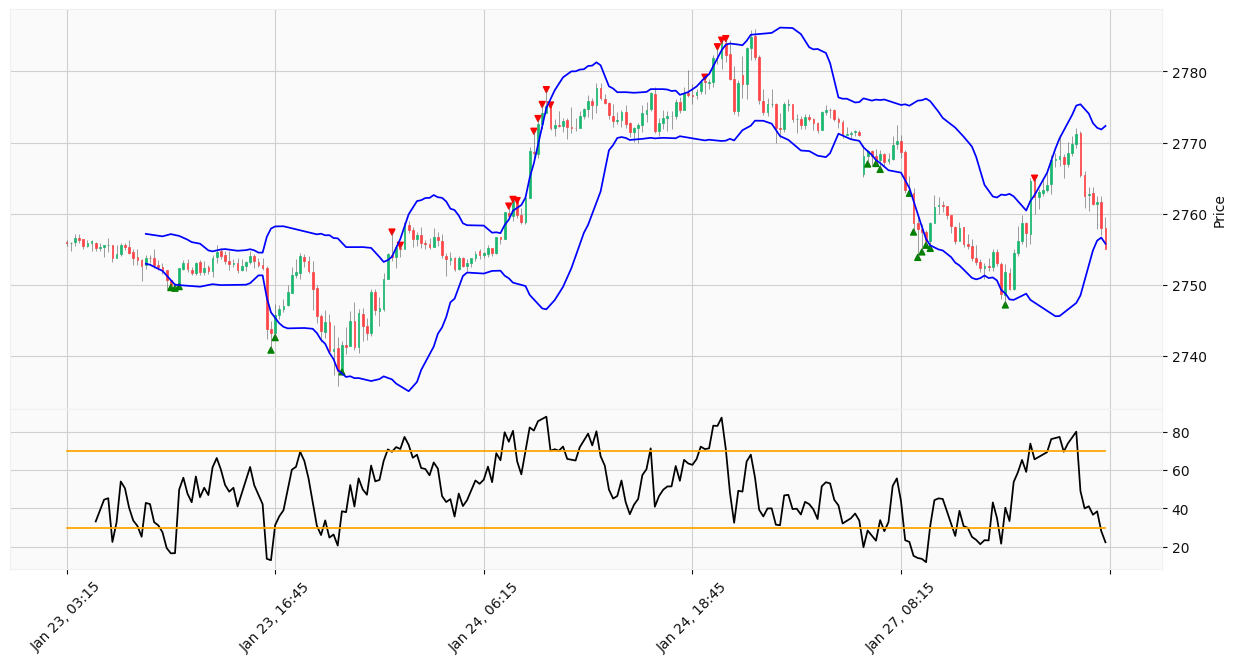

In [61]:
mpf.plot(df, type='candle', style='yahoo', addplot=plot_to_add, figsize=(16,8))
# mpf.plot(df, type='candle', style='yahoo', figsize=(16,8), addplot=plot_to_add)
# mpf.plot(df, type='candle', style='yahoo', figsize=(16,8))

# Backtest

In [134]:
import pandas as pd
import pandas_ta as ta
from backtesting import Backtest, Strategy

In [135]:
df.rename(columns={
    'open': 'Open',
    'close': 'Close',
    'high': 'High',
    'low': 'Low'
}, inplace=True)

In [136]:
# # Calculate indicators using pandas-ta
# df['EMA_50'] = ta.ema(df['Close'], length=50)
# df['EMA_100'] = ta.ema(df['Close'], length=100)
# df['EMA_150'] = ta.ema(df['Close'], length=150)
# df['ATR'] = ta.atr(df['High'], df['Low'], df['Close'], length=14)

# # Drop rows with NaN values from indicator calculations
# df.dropna(inplace=True)

# class EMAPullbackStrategy(Strategy):
#     risk_reward_ratio = 1.5  # Risk-reward ratio for SL/TP

#     def init(self):
#         # Nothing to initialize here, as we have indicators calculated outside

#         pass

#     def next(self):
#         # Use the length of the data to get the position
#         pos = len(self.data) - 1
        
#         # Access precomputed indicators directly from self.data.df
#         ema_50 = self.data.df['EMA_50'].iloc[pos]
#         ema_100 = self.data.df['EMA_100'].iloc[pos]
#         ema_150 = self.data.df['EMA_150'].iloc[pos]
#         atr_value = self.data.df['ATR'].iloc[pos]

#         # Calculate trends
#         uptrend = (ema_50 > ema_100) and (ema_100 > ema_150)
#         downtrend = (ema_50 < ema_100) and (ema_100 < ema_150)

#         # Pullback conditions
#         pullback_buy = (self.data.Low.iloc[pos] < ema_50) and (self.data.Low.iloc[pos] > ema_150)
#         pullback_sell = (self.data.High.iloc[pos] > ema_50) and (self.data.High.iloc[pos] < ema_150)

#         # ATR-based SL and TP
#         sl_price = atr_value  # Stop-loss distance
#         tp_price = sl_price * self.risk_reward_ratio  # Take-profit distance

#         # Buy signal
#         if pullback_buy and downtrend:
#             print("Buy signal triggered")
#             self.buy(sl=self.data.df['Close'].iloc[pos] - sl_price, tp=self.data.df['Close'].iloc[pos] + tp_price)

#         # Sell signal
#         if pullback_sell and uptrend:
#             print("Sell signal triggered")
#             self.sell(sl=self.data.df['Close'].iloc[pos] + sl_price, tp=self.data.df['Close'].iloc[pos] - tp_price)

# # Run the backtest
# bt = Backtest(df, EMAPullbackStrategy, cash=10000, commission=0.001, exclusive_orders=True)
# stats = bt.run()

# # Print the backtest statistics
# print(stats)

# # Plot the results
# bt.plot()

In [137]:
# import backtrader as bt
# import pandas as pd

# # Custom strategy class
# class EMAPullbackStrategy(bt.Strategy):
#     params = (
#         ('ema_50_period', 50),
#         ('ema_100_period', 100),
#         ('ema_150_period', 150),
#         ('atr_period', 14),
#         ('risk_reward_ratio', 1.5),  # SL:TP ratio
#     )

#     def __init__(self):
#         # Indicators
#         self.ema_50 = bt.indicators.EMA(self.data.close, period=self.params.ema_50_period)
#         self.ema_100 = bt.indicators.EMA(self.data.close, period=self.params.ema_100_period)
#         self.ema_150 = bt.indicators.EMA(self.data.close, period=self.params.ema_150_period)
#         self.atr = bt.indicators.ATR(self.data, period=self.params.atr_period)
        
#         # Will calculate fractals manually based on past high/low levels
#         # self.fractals_up = bt.indicators.Fractal(self.data).fractal_high
#         # self.fractals_down = bt.indicators.Fractal(self.data).fractal_low

#     def next(self):
#         # Check if we're in an uptrend or downtrend based on EMA's
#         uptrend = (self.ema_50[-1] > self.ema_100[-1]) and (self.ema_100[-1] > self.ema_150[-1])
#         downtrend = (self.ema_50[-1] < self.ema_100[-1]) and (self.ema_100[-1] < self.ema_150[-1])

#         # Pullback conditions
#         pullback_buy = (self.data.low[-1] < self.ema_50[-1]) and (self.data.low[-1] > self.ema_150[-1])
#         pullback_sell = (self.data.high[-1] > self.ema_50[-1]) and (self.data.high[-1] < self.ema_150[-1])

#         # Buy condition
#         # if pullback_buy and downtrend and self.fractals_down[-2]:
#         if pullback_buy and downtrend:
#             atr_value = self.atr[0]
#             stop_loss = self.data.close[0] - atr_value
#             take_profit = self.data.close[0] + (atr_value * self.params.risk_reward_ratio)
#             self.buy_bracket(
#                 price=self.data.close[0], 
#                 stopprice=stop_loss, 
#                 limitprice=take_profit
#             )

#         # Sell condition
#         # if pullback_sell and uptrend and self.fractals_up[-2]:
#         if pullback_sell and uptrend:
#             atr_value = self.atr[0]
#             stop_loss = self.data.close[0] + atr_value
#             take_profit = self.data.close[0] - (atr_value * self.params.risk_reward_ratio)
#             self.sell_bracket(
#                 price=self.data.close[0], 
#                 stopprice=stop_loss, 
#                 limitprice=take_profit
#             )

# # Backtest function
# def run_backtest(data):
#     cerebro = bt.Cerebro()
#     cerebro.addstrategy(EMAPullbackStrategy)

#     # Add data to cerebro
#     data_feed = bt.feeds.PandasData(dataname=data)
#     cerebro.adddata(data_feed)

#     # Set starting cash
#     cerebro.broker.setcash(10000.0)

#     # Set commission (optional)
#     cerebro.broker.setcommission(commission=0.00)

#     # Run backtest
#     print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
#     cerebro.run()
#     print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

#     # Plot the result
#     cerebro.plot()

# # Load your data (ensure the 'Date' column is the index)

# # Run the backtest
# run_backtest(df)
